In [1]:
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.opflow import Z, I, X
from qiskit.opflow import StateFn, CircuitStateFn
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.opflow import Gradient, NaturalGradient, QFI, Hessian
from IQPImplementation import IQP
from qiskit.algorithms.optimizers import GradientDescent
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt



In [2]:
backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 1024, seed_simulator = 2718, seed_transpiler = 2718)

In [5]:
# We will implement the efficientSU2 ansatz
def efficientSU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular'):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('θ', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims

        qc.compose(entanglement(), range(N_dims), inplace=True)
        
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims
    
    return qc

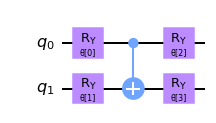

ListOp([
  SummedOp([
    5.0 * ComposedOp([
      OperatorMeasurement(ZI),
      CircuitStateFn(
           ┌────────────────────────────────────────────┐
      q_0: ┤0                                           ├
           │  RealAmplitudes(θ[0] + 0.1,θ[1],θ[2],θ[3]) │
      q_1: ┤1                                           ├
           └────────────────────────────────────────────┘
      )
    ]),
    -5.0 * ComposedOp([
      OperatorMeasurement(ZI),
      CircuitStateFn(
           ┌────────────────────────────────────────────┐
      q_0: ┤0                                           ├
           │  RealAmplitudes(θ[0] - 0.1,θ[1],θ[2],θ[3]) │
      q_1: ┤1                                           ├
           └────────────────────────────────────────────┘
      )
    ])
  ]),
  SummedOp([
    5.0 * ComposedOp([
      OperatorMeasurement(ZI),
      CircuitStateFn(
           ┌────────────────────────────────────────────┐
      q_0: ┤0                                           ├
   

In [6]:
ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear')
ansatz.draw('mpl', style='iqx')

hamiltonian = Z ^ I

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

display(ansatz.decompose().draw('mpl'))

sampler = CircuitSampler(q_instance)

eps = 0.1
index = 2
point = [0.5 for i in range(ansatz.num_parameters)]
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
expectation = ~StateFn(hamiltonian) @ CircuitStateFn(primitive=ansatz, coeff=1.)
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[0::])
print(grad)

In [5]:
value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval()

[(0.234375+0j),
 (-0.16601562499999956+0j),
 (0.25390624999999956+0j),
 (0.25390624999999956+0j)]

In [6]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(operator=expectation)
sampler.convert(grad, value_dict).eval()

[(-0.34375000000000006+0j),
 (-0.7822265625+0j),
 (0.025390625+0j),
 (-0.7910156249999999+0j)]

In [7]:
qc = IQP(2)
point = [0.5,0.5,0.5]
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)


qc.assign_parameters(expectation.parameters)
shifter = Gradient('lin_comb')  # parameter-shift rule is the default
grad = shifter.convert(operator=expectation)
sampler.convert(grad, value_dict).eval()

[(-0.029296875000000056+0j), (-0.640625+0j), (-0.41503906250000006+0j)]

In [8]:
qc = IQP(2)
point = [0.5,0.5,0.5]
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)

nat_grad = NaturalGradient(grad_method='lin_comb', qfi_method='lin_comb_full', regularization='ridge')
grad = nat_grad.convert(operator=expectation)
sampler.convert(grad, value_dict).eval()

array([ 1.46522411, -0.94979978, -0.02916186])

In [9]:
hessian = Hessian()
nat_grad = NaturalGradient()
grad = hessian.convert(operator=expectation)
sampler.convert(grad, value_dict).eval()

array([[ 0.00146484+0.j,  0.0078125 +0.j,  0.0012207 +0.j],
       [ 0.0078125 +0.j, -0.7265625 +0.j, -0.26342773+0.j],
       [ 0.0012207 +0.j, -0.26342773+0.j, -0.25415039+0.j]])

Let's try to demonstrate some optimization differences.

In [16]:
qc = IQP(3)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))

gradient = Gradient('fin_diff', eps=0.01).convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossFinDiff = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossFinDiff.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [17]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

In [18]:
qc = IQP(3)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))


gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossParamShift = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossParamShift.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [19]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

In [20]:
qc = IQP(3)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))


gradient = Gradient('lin_comb').convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossLinComb = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossLinComb.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [21]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

In [22]:
qc = IQP(3)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))

gradient = NaturalGradient(grad_method='param_shift', qfi_method='lin_comb_full').convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance, caching="all")


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossNatGrad = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossNatGrad.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [23]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

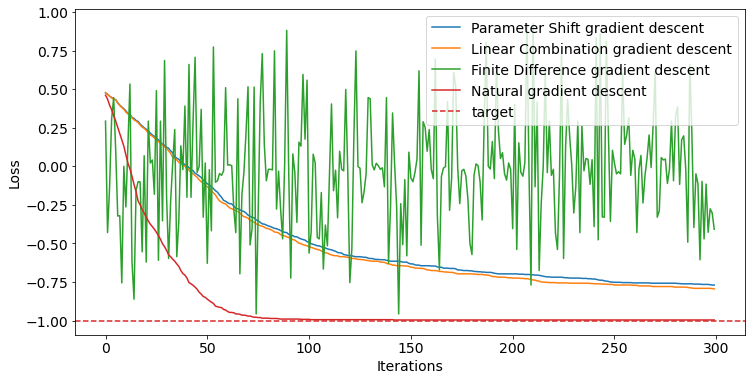

In [24]:
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(12, 6))
plt.plot(gd_lossParamShift, label='Parameter Shift gradient descent')
plt.plot(gd_lossLinComb, label='Linear Combination gradient descent')
plt.plot(gd_lossFinDiff, label='Finite Difference gradient descent')
plt.plot(gd_lossNatGrad, label='Natural gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend();
plt.savefig('IQPGradient.png')

In [26]:
qc = efficientSU2(2)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))


gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossParamShift = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossParamShift.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [27]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

In [28]:
qc = efficientSU2(2)
point = np.array([0.5 for i in qc.parameters[0::]])
value_dict = dict(zip(qc.parameters, point))
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qc))


gradient = Gradient('lin_comb').convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)


def evaluate_expectation(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(qc.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)

gd_lossLinComb = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_lossLinComb.append(fx)
    
gd = GradientDescent(maxiter=300, callback=gd_callback)

In [29]:
x_opt, fx_opt, nfevs = gd.optimize(point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=point)  # initial point

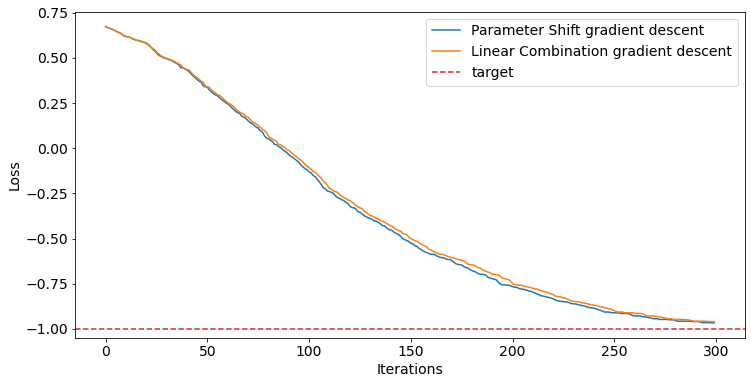

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(gd_lossParamShift, label='Parameter Shift gradient descent')
plt.plot(gd_lossLinComb, label='Linear Combination gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend();
plt.savefig("ESU2Grad.png")